In [4]:
using Revise

In [25]:
using StatsPlots

In [5]:
using Aggregator
import Aggregator.Db

In [6]:
data = generate_data(11, 22)

Dict{ReviewInfo,Aggregator.MangroveBase.ReviewContent} with 22 entries:
  ReviewInfo("0", "11")  => ReviewContent(0, missing)
  ReviewInfo("2", "13")  => ReviewContent(20, missing)
  ReviewInfo("10", "21") => ReviewContent(100, missing)
  ReviewInfo("3", "3")   => ReviewContent(30, missing)
  ReviewInfo("7", "18")  => ReviewContent(70, missing)
  ReviewInfo("6", "6")   => ReviewContent(60, missing)
  ReviewInfo("7", "7")   => ReviewContent(70, missing)
  ReviewInfo("4", "15")  => ReviewContent(40, missing)
  ReviewInfo("1", "1")   => ReviewContent(10, missing)
  ReviewInfo("8", "19")  => ReviewContent(80, missing)
  ReviewInfo("0", "0")   => ReviewContent(0, missing)
  ReviewInfo("8", "8")   => ReviewContent(80, missing)
  ReviewInfo("6", "17")  => ReviewContent(60, missing)
  ReviewInfo("10", "10") => ReviewContent(100, missing)
  ReviewInfo("1", "12")  => ReviewContent(10, missing)
  ReviewInfo("5", "16")  => ReviewContent(50, missing)
  ReviewInfo("4", "4")   => ReviewContent(40, mi

In [21]:
data = Aggregator.Api.mangrove_reviews();

In [23]:
data = Db.mangrove_reviews()

Dict{RatingInfo,Int64} with 6 entries:
  RatingInfo("urn:maresi:OSx0SnroK-67jKAkFUQJ-MPw9IUT5J1ltas4A_q4646MKXZ… => 100
  RatingInfo("geo:47.2878393,8.54072945?q=Schloss Langnau&u=30", "-----B… => 75
  RatingInfo("https://example.com", "-----BEGIN PUBLIC KEY-----MFkwEwYHK… => 50
  RatingInfo("geo:47.1691576,8.514572?q=Juanitos&u=30", "-----BEGIN PUBL… => 75
  RatingInfo("https://example.com", "-----BEGIN PUBLIC KEY-----MFkwEwYHK… => 75
  RatingInfo("geo:47.1691576,8.514572?q=Juanitos&u=30", "-----BEGIN PUBL… => 75

In [7]:
using Turing

In [8]:
using Aggregator.MangroveBase: Reviews, ReviewsSummary, kids
using Aggregator.Model: MeanBeta

In [9]:
@model mangrove_model(data, typical_rating) = begin
    # Assume that each subject has a fundamental quality associated with it.
    # Extreme qualities are not as likely as moderate ones.
    qualities = Dict()
    for sub in subs(data)
        qualities[sub] ~ MeanBeta(typical_rating)
    end
    # Assume that each reviewer is either neutral (0) or biased (1).
    biases = Dict()
    for kid in kids(data)
        biases[kid] ~ Bernoulli(0.3)
    end
    # Observe the ratings from the dataset, which depend on quality and bias.
    for info in keys(data)
      if biases[info.kid] == 0
            # Neutral reviewer leaves a review which reflects the quality.
            data[info][1] ~ MeanBeta(qualities[info.sub])
        else
            # Biased reviewers are mostly negative and pay not attention to actual quality.
            data[info][1] ~ Beta(0.04, 0.08)
        end
    end
    return collect(values(qualities))
end

##mangrove_model#468 (generic function with 2 methods)

In [31]:
function get_chains(raw_data::Reviews)::Chains
    data = convert(ReviewsSummary, raw_data)
    typical_rating = mean(values(data))
    sampler = PG(500)
    sample(mangrove_model(data, typical_rating), sampler, 100)
end

get_chains (generic function with 1 method)

In [53]:
mean(chn[:biases]) |> neutralities

15-element Array{Float64,1}:
 0.08
 0.18
 0.52
 0.3 
 0.39
 0.43
 0.0 
 0.04
 0.44
 0.0 
 0.0 
 0.0 
 0.09
 0.52
 0.09

In [32]:
chn = get_chains(data)

Progress: 100%|█████████████████████████████████████████| Time: 0:02:48


Object of type Chains, with data of type 100×59×1 Array{Real,3}

Log evidence      = 9.430513339055622
Iterations        = 1:100
Thinning interval = 1
Chains            = 1
Samples per chain = 100
internals         = le, lp, weight
parameters        = biases[-----BEGIN PUBLIC KEY-----MFkwEwYHKoZIzj0CAQYIKoZIzj0DAQcDQgAE5KBvUwg0Cpi8a261gsEmAzLOnqMREbx1+tCymWkAJlHztNmuvxaef1k/akI1tJGMiqnQO5XDZj8jGc2FfF9KGQ==-----END PUBLIC KEY-----], biases[-----BEGIN PUBLIC KEY-----MFkwEwYHKoZIzj0CAQYIKoZIzj0DAQcDQgAE74stEm/IYXlprKXh+3lQuwZbRBqc0a4JEV3MK+9A5bsEw3oMMR0+xUKOEXyrbUzBJvq5O77WyC+hFPbSVzQmYw==-----END PUBLIC KEY-----], biases[-----BEGIN PUBLIC KEY-----MFkwEwYHKoZIzj0CAQYIKoZIzj0DAQcDQgAE347DkgEeB9ZopzdvqBMtAgsYGzf8VhtuJREsCo1ZxMuOlbajBmb908Aic1tPN+mrA2Arh264etO/Bz/fFUJKFQ==-----END PUBLIC KEY-----], biases[-----BEGIN PUBLIC KEY-----MFkwEwYHKoZIzj0CAQYIKoZIzj0DAQcDQgAE+XHkrBWcgf6OtIJiK8Tj/2L4dItR27LDhsW28rDcLPgzs26ZyN7qNLQ2IFr4C2E4vTH1wQnRthfhJ6RO/+SZJw==-----END PUBLIC KEY-----], biases[-----

In [24]:
mean(chn[:qualities])

Mean
                                                                                                    parameters    mean
  ────────────────────────────────────────────────────────────────────────────────────────────────────────────  ──────
                                         qualities[geo:46.414202849999995,6.9275531?q=Château de Chillon&u=30]  0.7171
                                                        qualities[geo:47.0002812,8.3983246?q=Bürgenstock&u=30]  0.7425
                                                            qualities[geo:47.0505452,8.3054682?q=Lucerne&u=30]  0.8551
                                                               qualities[geo:47.0511141,8.29512?q=Gütsch&u=30]  0.7461
                                                          qualities[geo:47.1437602,8.5337843?q=Zugerberg&u=30]  0.6012
                                                          qualities[geo:47.1671127,8.5157744?q=Juan Long&u=30]  0.7107
                                           

In [19]:
[r for (info, r) in data if info.kid=="11"]

1-element Array{Aggregator.MangroveBase.ReviewContent,1}:
 Aggregator.MangroveBase.ReviewContent(0, missing)

In [42]:
using StatsPlots

In [125]:
import StatsPlots.histogram

In [97]:
MeanBeta(mean::Real, certainty::Real = 3) = Beta(certainty * mean, certainty * (1 - mean))

┌ Error: Failed to revise /home/keorn/Documents/mangrove/aggregator/src/Model.jl
│   exception = (StackOverflowError(), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x00007fc845e9760a])
└ @ Revise /home/keorn/.julia/packages/Revise/SZ4ae/src/Revise.jl:590
┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│ 
│   /home/keorn/Documents/mangrove/aggregator/src/Model.jl
│ 
│ Use Revise.errors() to report errors again.
└ @ Revise /home/keorn/.julia/packages/Revise/SZ4ae/src/Revise.jl:648


MeanBeta (generic function with 2 methods)

In [131]:
histogram(d::Distribution, samples::Integer = 1000) = histogram([rand(d) for _ in 1:samples])

histogram (generic function with 3 methods)

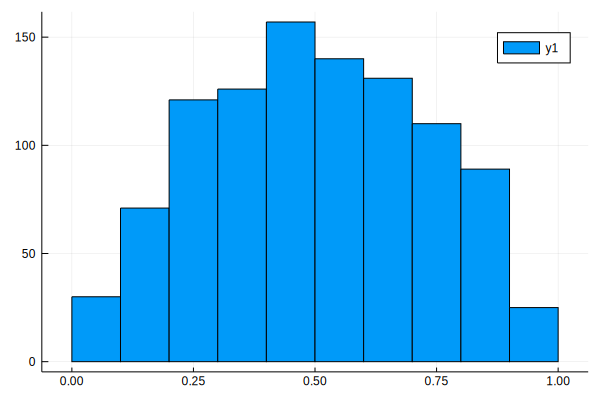

In [132]:
histogram(Beta(2, 2))

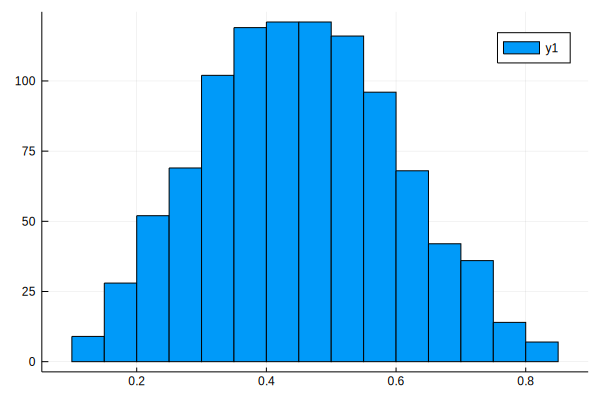

In [153]:
histogram([rand(Dirichlet([5, 5, 1]))[1] for _ in 1:1000])

In [73]:
@model min_model(xs) = begin
    for x in xs
        choice ~ Bernoulli(0.3)
        if choice == 0
            x ~ Beta(1, 10)
        else
            x ~ Beta(10, 1)
        end
    end
end

function get_chains(data)::Chains
    sample(min_model(data), PG(10), 100)
end

get_chains (generic function with 2 methods)

In [38]:
using Aggregator.Job: store_qualities

┌ Error: Failed to revise /home/keorn/Documents/mangrove/aggregator/src/Model.jl
│   exception = (StackOverflowError(), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x00007f7d83b9f93a])
└ @ Revise /home/keorn/.julia/packages/Revise/SZ4ae/src/Revise.jl:590
┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│ 
│   /home/keorn/Documents/mangrove/aggregator/src/Model.jl
│ 
│ Use Revise.errors() to report errors again.
└ @ Revise /home/keorn/.julia/packages/Revise/SZ4ae/src/Revise.jl:648


In [39]:
store_qualities()

┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│ 
│   /home/keorn/Documents/mangrove/aggregator/src/Model.jl
│ 
│ Use Revise.errors() to report errors again.
└ @ Revise /home/keorn/.julia/packages/Revise/SZ4ae/src/Revise.jl:648


MethodError: MethodError: no method matching get_chains(::Dict{ReviewInfo,Aggregator.MangroveBase.ReviewContent})
Closest candidates are:
  get_chains(!Matched::Dict{ReviewInfo,Tuple{Float64,Bool}}) at /home/keorn/Documents/mangrove/aggregator/src/Model.jl:20

In [74]:
get_chains(collect(0.1:0.1:0.9))

Object of type Chains, with data of type 100×5×1 Array{Real,3}

Log evidence      = 0.0
Iterations        = 1:100
Thinning interval = 1
Chains            = 1
Samples per chain = 100
internals         = le, lp, weight
parameters        = choice, x

2-element Array{ChainDataFrame,1}

Summary Statistics
  parameters    mean     std  naive_se     mcse       ess   r_hat
  ──────────  ──────  ──────  ────────  ───────  ────────  ──────
      choice  0.3700  0.4852    0.0485  missing  173.6090  0.9904
           x  0.4050  0.4174    0.0417  missing  188.9861  0.9900

Quantiles
  parameters    2.5%   25.0%   50.0%   75.0%   97.5%
  ──────────  ──────  ──────  ──────  ──────  ──────
      choice  0.0000  0.0000  0.0000  1.0000  1.0000
           x  0.0055  0.0482  0.1269  0.9104  0.9986


In [41]:
using Optim
function get_nlogp(model)
    # Construct a trace struct
    vi = Turing.VarInfo(model)

    # Define a function to optimize.
    function nlogp(qualities)
        spl = Turing.SampleFromPrior()
        new_vi = Turing.VarInfo(vi, spl, qualities)
        model(new_vi, spl)
        -Turing.getlogp(new_vi)
    end

    return nlogp
end

function get_opt(raw_data::MangroveData)::Chains
    normal_data = Dict{RatingInfo, Float64}()
    for key in keys(raw_data)
        normal_data[key] = normalize(raw_data[key])
    end
    typical_rating = mean(values(normal_data))
    nlogp = get_nlogp(mangrove_model(normal_data, typical_rating))
    # Create a starting point, call the optimizer.
    qualities_0 = fill(typical_rating, 11)
    lb = zeros(11)
    ub = ones(11)
    optimize(nlogp, lb, ub, qualities_0, Fminbox())
end
get_opt(raw_data)

get_opt (generic function with 1 method)